**The principle of working with Mediapipe**

In [1]:
!pip install mediapipe opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 64.3 MB/s eta 0:00:00


In [2]:
# We connect to Google Drive to get the necessary files from there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


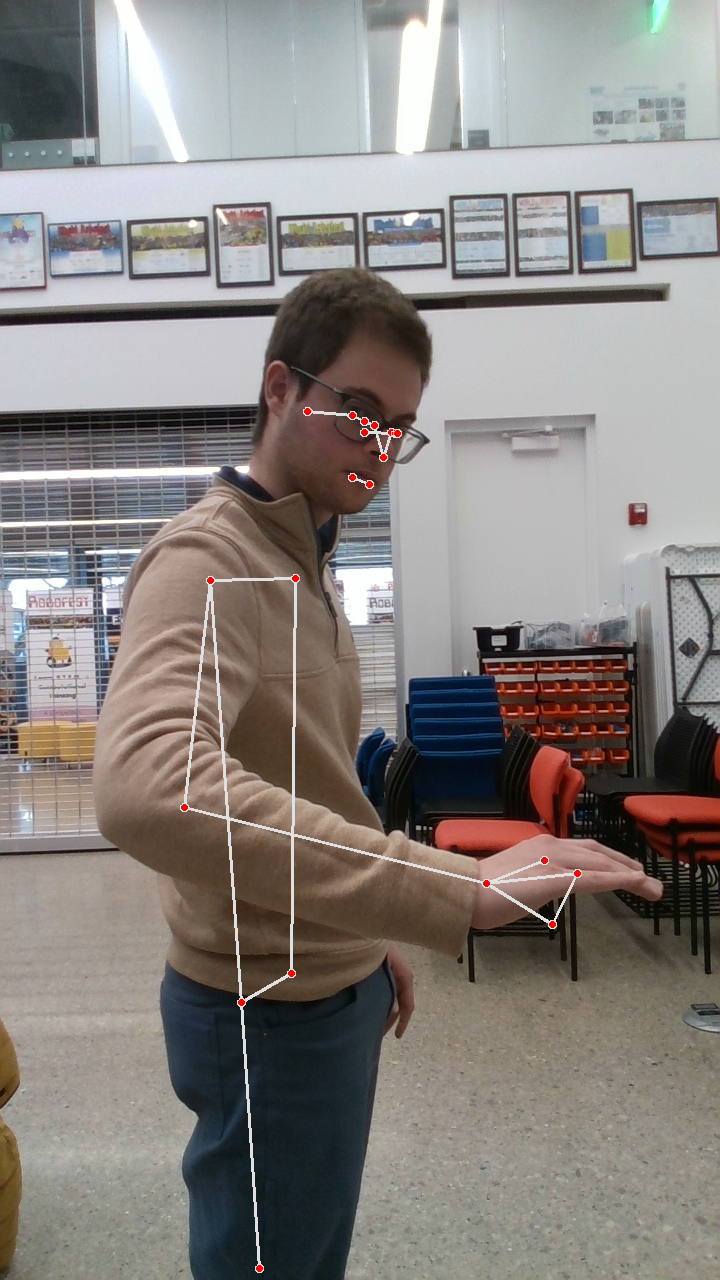

In [3]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow

# Initialize MediaPipe Pose Detection
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Load the sample image
image_path = "/content/drive/MyDrive/RoboticsAI_DATA/frame0056.jpg"  # Path to the uploaded image
frame = cv2.imread(image_path)

# Rotate the frame 90 degrees clockwise BEFORE processing
rotated_frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

# Convert the rotated frame to RGB (for MediaPipe)
frame_rgb = cv2.cvtColor(rotated_frame, cv2.COLOR_BGR2RGB)

# Process the rotated frame with MediaPipe Pose Detection
results = pose.process(frame_rgb)

# Draw pose landmarks on the rotated frame
rotated_frame.flags.writeable = True
mp_drawing.draw_landmarks(rotated_frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

# Display the rotated frame with landmarks
cv2_imshow(rotated_frame)  # Use this in Colab instead of cv2.imshow()

**Relevant Landmarks:**

For arm tracking, use the following landmarks:
*   RIGHT_SHOULDER: mp_pose.PoseLandmark.RIGHT_SHOULDER
*   RIGHT_ELBOW: mp_pose.PoseLandmark.RIGHT_ELBOW
*   LRIGHT_WRIST: mp_pose.PoseLandmark.RIGHT_WRIST


In [4]:
# Access and extract Y-coordinates (normalized)
if results.pose_landmarks:
    landmarks = results.pose_landmarks.landmark

    # Extract normalized X-coordinates
    shoulder_x = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x
    elbow_x = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x
    wrist_x = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x

    # Extract normalized Y-coordinates
    shoulder_y = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y
    elbow_y = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y
    wrist_y = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y


    # Print extracted X-coordinates
    print(f"Shoulder X: {shoulder_x}")
    print(f"Elbow X: {elbow_x}")
    print(f"Wrist X: {wrist_x}")

    print("----------------------------------")
    # Print extracted Y-coordinates
    print(f"Shoulder Y: {shoulder_y}")
    print(f"Elbow Y: {elbow_y}")
    print(f"Wrist Y: {wrist_y}")


Shoulder X: 0.29183802008628845
Elbow X: 0.25638601183891296
Wrist X: 0.6756198406219482
----------------------------------
Shoulder Y: 0.4535653591156006
Elbow Y: 0.6311851143836975
Wrist Y: 0.6904927492141724


In [5]:
# Get the frame dimensions
height, width, _ = frame.shape

# Convert normalized coordinates to pixel positions
wrist_x_pixel = int(landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x * width)
wrist_y_pixel = int(landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y * height)

# Print the 2D position of the shoulder
print(f"Wrist 2D Position: ({wrist_x_pixel}, {wrist_y_pixel})")


Wrist 2D Position: (864, 497)


## Hand height mimicry (main code)

In [ ]:
#!/usr/bin/env python3
import rospy
import cv2
import mediapipe as mp
from sensor_msgs.msg import Image, CameraInfo
from cv_bridge import CvBridge, CvBridgeError
from stretch_srvs.srv import MoveJoints, MoveJointsRequest
import numpy as np
import tf
import message_filters

class Batyr:
    def __init__(self):
        rospy.init_node('object_localize', anonymous=True)
        self.listener = tf.TransformListener()

        # Initialize CvBridge
        self.bridge = CvBridge()

        # Initialize MediaPipe Pose Detection
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.7)

        # Camera parameters and base height
        self.params = None
        self.camera_base_height = 0.12827  # Measured camera height from the beginning of the movement of the robotic arm(lower base)
        self.wrist_positions = []  # For smoothing

        # Subscribers for RGB and Depth
        self.camera_params_sub = rospy.Subscriber('/camera_throttled/depth/camera_info', CameraInfo, self.cam_info_callback)
        self.rgb_sub = message_filters.Subscriber('/camera_throttled/color/image_raw', Image)
        self.depth_sub = message_filters.Subscriber('/camera_throttled/depth/image_rect_raw', Image)

        # Synchronize RGB and Depth topics
        self.ts = message_filters.ApproximateTimeSynchronizer([self.rgb_sub, self.depth_sub], 10, 0.1)
        self.ts.registerCallback(self.rgbd_callback)

        # Wait for the arm service
        rospy.wait_for_service('/funmap/move_joints')
        self.move_arm = rospy.ServiceProxy('/funmap/move_joints', MoveJoints)

    def cam_info_callback(self, cam_info: CameraInfo):
        self.params = {
            "fx": cam_info.K[0],
            "fy": cam_info.K[4],
            "cx": cam_info.K[2],
            "cy": cam_info.K[5],
        }
        rospy.loginfo(f"Camera parameters initialized: {self.params}")
        self.camera_params_sub.unregister()  # Unsubscribe after receiving camera info

    def move_robot_arm(self, wrist_height):
        # Limit the height to the robot's arm range
        max_height = 1.0668  # Maximum arm height (in meters)
        min_height = 0.1778  # Minimum arm height (in meters)
        wrist_height = max(min(wrist_height, max_height), min_height)

        # Create the request for the MoveJoints service
        pose = MoveJointsRequest()
        pose.joint_names = ['joint_lift']  # Only control the lift joint for vertical movement
        pose.positions = [wrist_height]  # Set the target height for the lift joint

        try:
            # Call the service
            response = self.move_arm(pose)
            rospy.loginfo(f"Robotic arm moved to height(From the foundation): {wrist_height:.2f} meters")
        except rospy.ServiceException as e:
            rospy.logerr(f"Service call failed: {e}")

    def rgbd_callback(self, rgb_img: Image, depth_img: Image):
        if not self.params:
            rospy.logerr("Camera parameters are not initialized yet.")
            return

        try:
            # Convert ROS image to OpenCV format
            cv_image_rgb = self.bridge.imgmsg_to_cv2(rgb_img, "bgr8")
            cv_image_depth = self.bridge.imgmsg_to_cv2(depth_img, desired_encoding='passthrough')
        except CvBridgeError as e:
            rospy.logerr(f"CvBridge Error: {e}")
            return

        # Process image with MediaPipe Pose
        frame_rgb = cv2.cvtColor(cv_image_rgb, cv2.COLOR_BGR2RGB)
        results = self.pose.process(frame_rgb)

        # Skip if wrist landmarks are not detected
        if not results.pose_landmarks:
            rospy.loginfo("No wrist detected.")
            return

        # Extract wrist coordinates
        landmarks = results.pose_landmarks.landmark
        wrist_x = landmarks[self.mp_pose.PoseLandmark.RIGHT_WRIST].x
        wrist_y = landmarks[self.mp_pose.PoseLandmark.RIGHT_WRIST].y

        # Convert normalized coordinates to pixel positions
        wrist_x_pixel = int(wrist_x * cv_image_depth.shape[1])
        wrist_y_pixel = int(wrist_y * cv_image_depth.shape[0])

        # Check if wrist is within image bounds
        if not (0 <= wrist_x_pixel < cv_image_depth.shape[1] and 0 <= wrist_y_pixel < cv_image_depth.shape[0]):
            rospy.logwarn("Wrist coordinates are out of bounds.")
            return

        # Retrieve depth at wrist position
        depth_value = cv_image_depth[wrist_y_pixel, wrist_x_pixel]
        if depth_value > 0 and depth_value <= 10000:  # Valid depth range in mm
            depth_value /= 1000.0  # Convert depth to meters
        else:
            rospy.logwarn(f"Invalid depth value: {depth_value}")
            return

        rospy.loginfo(f"Depth at wrist: {depth_value:.2f} meters")

        # Transform wrist coordinates to world frame
        try:
            (trans, rot) = self.listener.lookupTransform('/base_link', depth_img.header.frame_id, depth_img.header.stamp)
            base_relativeM = np.matmul(tf.transformations.translation_matrix(trans), tf.transformations.quaternion_matrix(rot))
            rospy.loginfo(f"Base-relative transformation matrix: \n{base_relativeM}")

            # Normalize wrist coordinates
            fx = self.params["fx"]
            fy = self.params["fy"]
            cx = self.params["cx"]
            cy = self.params["cy"]
            wrist_x_normalized = (wrist_x_pixel - cx) / fx
            wrist_y_normalized = (wrist_y_pixel - cy) / fy

            # Calculate wrist position in camera frame
            point_camera_frame = np.array([
                wrist_x_normalized * depth_value,
                wrist_y_normalized * depth_value,
                depth_value,
                1,
            ])
            point_world_frame = np.dot(base_relativeM, point_camera_frame)

            rospy.loginfo(f"3D Point in World Frame: {point_world_frame}")

            # Adjust wrist height using camera base height
            wrist_height = point_world_frame[2] + self.camera_base_height

            # Apply offset correction
            corrected_wrist_height = wrist_height - 0.1651

            # Smooth wrist height using moving average
            # self.wrist_positions.append(corrected_wrist_height)
            # if len(self.wrist_positions) > 5:
            #     self.wrist_positions.pop(0)
            # smoothed_height = sum(self.wrist_positions) / len(self.wrist_positions)



            smoothed_height = corrected_wrist_height


            # Move the robot arm to the corrected height
            self.move_robot_arm(smoothed_height)

        except (tf.LookupException, tf.ConnectivityException, tf.ExtrapolationException) as e:
            rospy.logerr(f"TF Error: {e}")

            return



if __name__ == '__main__':
    Batyr()
    rospy.spin()